## 1. TCP with MSE Loss

In [88]:
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
#show the keys in the file
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)



['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)


In [89]:
#Predicted class
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat)
#Prob of predicted class
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class)


predicted class : [ 1 11  9 ... 11  9  1]
predicted probabilities : [0.544058   0.97347754 0.7518662  ... 0.96628433 0.9899086  0.9475812 ]
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : [0.4308202  0.97347754 0.23816009 ... 0.96628433 0.98990858 0.94758117]
true class labels : [ 8 11 11 ... 11  9  1]


In [90]:
#Computing ECE
def compute_ECE(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += prop_in_bin * np.abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece


### Using TCPr

In [91]:
def compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha):
    indicator = (y_true_class != y_hat).astype(float)
    numerator = p_y_star
    denominator = p_y_hat + (indicator * (p_y_star + alpha))
    tcp_star_targets = numerator / denominator
    return tcp_star_targets

tcp_star_targets = compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha=0.3)
print("tcp_star_targets shape:", tcp_star_targets)

tcp_star_targets shape: [0.33793047 1.         0.18461646 ... 1.         1.         1.        ]


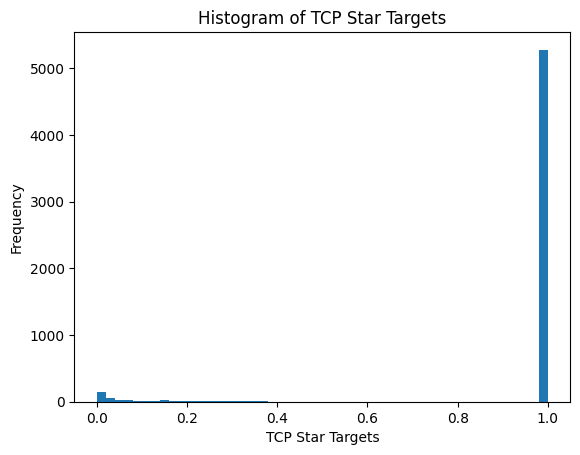

In [92]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [93]:
# Upsampling the errors to create a balanced batch 

# Select indices
correct_idx = np.where(y_hat == y_true_class)[0]
error_idx = np.where(y_hat != y_true_class)[0]

# You can duplicate errors to balance them
n_errors = len(error_idx)
n_correct = len(correct_idx)
upsample_errors = np.random.choice(error_idx, size=n_correct, replace=True)

balanced_idx = np.concatenate([correct_idx, upsample_errors])
np.random.shuffle(balanced_idx)

X_balanced = embeddings[balanced_idx]
y_balanced = tcp_star_targets[balanced_idx]
print("Balanced embeddings shape:", X_balanced.shape)
print("Balanced TCP Star Targets shape:", y_balanced.shape)

Balanced embeddings shape: (10552, 64)
Balanced TCP Star Targets shape: (10552,)


In [94]:
n_correct


5276

In [95]:
X=X_balanced
y=y_balanced

In [96]:
from sklearn.model_selection import train_test_split

# 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [97]:
import torch.nn as nn

class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


In [98]:
# # Weighted Sampling to focus on errors 
# # Biasing sampling towards harder cases

# import torch
# from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

# # Create sample weights: 1.0 for correct, 2.0 for errors
# is_error = (y_hat != y_true_class).astype(float)
# sample_weights = torch.tensor(1.0 + is_error, dtype=torch.float32)

# # Weighted sampler
# sampler = WeightedRandomSampler(weights=sample_weights,
#                                  num_samples=len(sample_weights),
#                                  replacement=True)


In [99]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset= TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

input_dim = X_train.shape[1]
output_dim = 1
model = ConfidenceNet(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()

# Training the model
for epoch in range(50):
    model.train()
    train_losses=[]
    for xb, yb in train_loader:
        pred=model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {sum(train_losses)/len(train_losses):.6f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.6f}")

Epoch 01 | Train Loss: 0.137590 | Val Loss: 0.120858
Epoch 02 | Train Loss: 0.113611 | Val Loss: 0.111525
Epoch 03 | Train Loss: 0.106594 | Val Loss: 0.097060
Epoch 04 | Train Loss: 0.098373 | Val Loss: 0.103533
Epoch 05 | Train Loss: 0.092172 | Val Loss: 0.091135
Epoch 06 | Train Loss: 0.086110 | Val Loss: 0.082052
Epoch 07 | Train Loss: 0.079241 | Val Loss: 0.079752
Epoch 08 | Train Loss: 0.075294 | Val Loss: 0.089465
Epoch 09 | Train Loss: 0.072760 | Val Loss: 0.076587
Epoch 10 | Train Loss: 0.066409 | Val Loss: 0.075344
Epoch 11 | Train Loss: 0.061032 | Val Loss: 0.070076
Epoch 12 | Train Loss: 0.063292 | Val Loss: 0.068149
Epoch 13 | Train Loss: 0.057076 | Val Loss: 0.057349
Epoch 14 | Train Loss: 0.054498 | Val Loss: 0.066607
Epoch 15 | Train Loss: 0.050093 | Val Loss: 0.054717
Epoch 16 | Train Loss: 0.045951 | Val Loss: 0.056912
Epoch 17 | Train Loss: 0.047281 | Val Loss: 0.059858
Epoch 18 | Train Loss: 0.043998 | Val Loss: 0.055227
Epoch 19 | Train Loss: 0.040127 | Val Loss: 0.

In [100]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_tcpr = model(X_test_tensor).numpy()  # shape: (5702,)
print("Confidence scores shape:", confidence_scores_tcpr.shape) #score from the final sigmoid layer

Confidence scores shape: (5702,)


In [101]:
#min and max values of confidence scores
print("Min value in confidence scores:", np.min(confidence_scores_tcpr))
print("Max value in confidence scores:", np.max(confidence_scores_tcpr))

Min value in confidence scores: 0.0004819048
Max value in confidence scores: 1.0


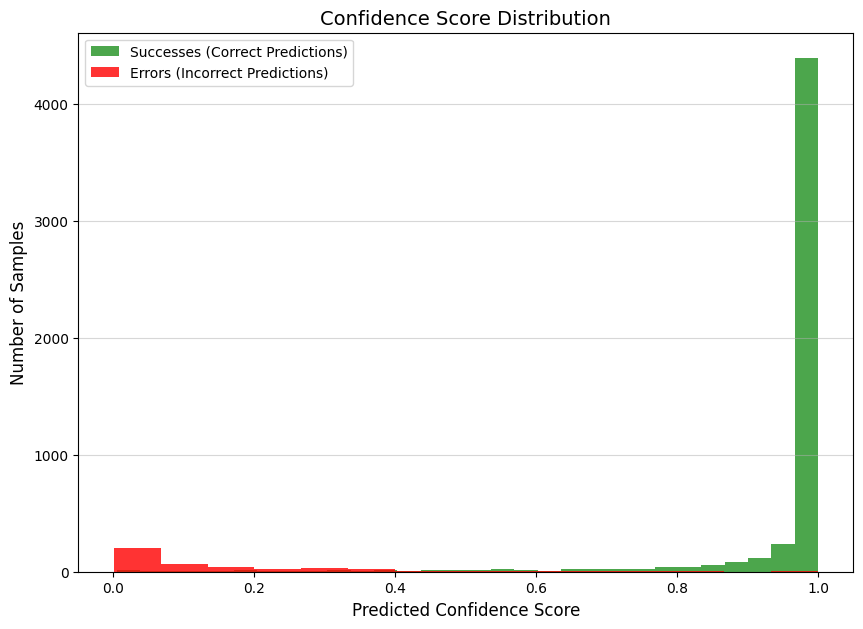

In [102]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)
is_correct = (y_hat == y_true_class)
success_confidences = confidence_scores_tcpr[is_correct]
error_confidences = confidence_scores_tcpr[~is_correct]

plt.figure(figsize=(10, 7))
# bins = np.linspace(0, 1, 50)
# plt.hist(success_confidences, bins=bins, alpha=0.7, label='Success', color='green')
# plt.hist(error_confidences, bins=bins, alpha=0.7, label='Error', color='red')

plt.hist(success_confidences, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
plt.hist(error_confidences, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')
plt.xlabel('Predicted Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Score Distribution', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()



In [103]:
ece_confidnet= compute_ECE(confidence_scores_tcpr, y_hat, y_labels_int)
print(f"ECE for Your Learned Confidence Model (TCP*): {ece_confidnet:.4f}")

ECE for Your Learned Confidence Model (TCP*): 0.0294


In [104]:
from sklearn.metrics import classification_report, accuracy_score

# BASELINE performance on the ENTIRE dataset
print("--- Baseline Performance (All 5702 Samples) ---")
print(classification_report(y_labels_int, y_hat, target_names=label_encoder.classes_))
print(f"Overall Baseline Accuracy: {accuracy_score(y_labels_int, y_hat):.4f}\n")

#Choose a confidence threshold
confidence_threshold = 0.3

high_confidence_mask = (confidence_scores >= confidence_threshold)

filtered_y_true = y_labels_int[high_confidence_mask]
filtered_y_pred = y_hat[high_confidence_mask]
print(f"--- Performance on High-Confidence Samples (Threshold = {confidence_threshold}) ---")
num_kept = len(filtered_y_true)
num_total = len(y_labels_int)
print(f"Kept {num_kept} of {num_total} samples ({num_kept/num_total:.2%}) for evaluation.\n")

if num_kept > 0:
    print(classification_report(filtered_y_true, filtered_y_pred, target_names=label_encoder.classes_))
    print(f"Accuracy on Filtered Set: {accuracy_score(filtered_y_true, filtered_y_pred):.4f}")
else:
    print("No samples remained after filtering with this threshold.")

--- Baseline Performance (All 5702 Samples) ---
                precision    recall  f1-score   support

      Bhairavi       0.91      0.96      0.93       220
         Bihag       0.89      0.95      0.92       655
           Des       0.83      0.78      0.80       150
           Jog       0.97      0.97      0.97       685
         Kedar       0.91      0.93      0.92       389
        Khamaj       0.75      0.79      0.77       198
      Malkauns       0.98      0.97      0.98       560
   Maru_bihaag       0.90      0.84      0.87       633
 Nayaki_kanada       0.98      0.97      0.97       499
Shuddha_kalyan       0.96      0.92      0.94       721
         Sohni       0.93      0.94      0.94       331
         Yaman       0.90      0.92      0.91       661

      accuracy                           0.93      5702
     macro avg       0.91      0.91      0.91      5702
  weighted avg       0.93      0.93      0.93      5702

Overall Baseline Accuracy: 0.9253

--- Performance on

### Using MCP

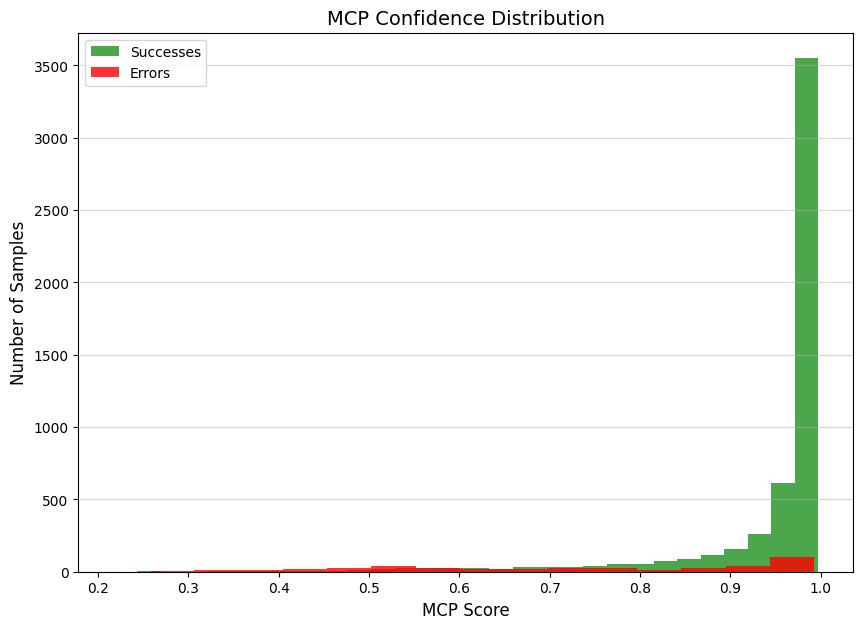

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

mcp_scores = np.max(probs, axis=1)
is_correct = (y_hat == y_labels_int)
mcp_success_confidences = mcp_scores[is_correct]
mcp_error_confidences = mcp_scores[~is_correct]

plt.figure(figsize=(10, 7))
plt.hist(mcp_success_confidences, bins=30, alpha=0.7, label='Successes', color='green')
plt.hist(mcp_error_confidences, bins=15, alpha=0.8, label='Errors', color='red')
plt.title('MCP Confidence Distribution', fontsize=14)
plt.xlabel('MCP Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


In [106]:
ece_mcp = compute_ECE(mcp_scores, y_hat, y_labels_int)
print(f"ECE for MCP Confidence Baseline: {ece_mcp:.4f}")    

ECE for MCP Confidence Baseline: 0.0120


### TCP

In [107]:
tcp_targets= p_y_star / p_y_hat
print(tcp_targets.shape)

(5702,)


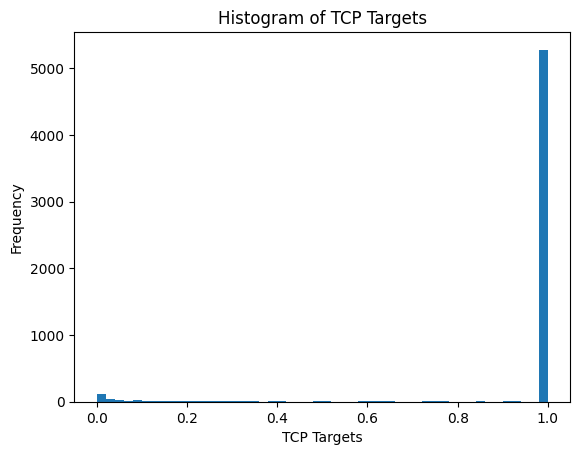

In [108]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_targets, bins=50)
plt.xlabel('TCP Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Targets')
plt.show()

In [109]:
# Upsampling the errors to create a balanced batch 

# Select indices
correct_idx = np.where(y_hat == y_true_class)[0]
error_idx = np.where(y_hat != y_true_class)[0]

# You can duplicate errors to balance them
n_errors = len(error_idx)
n_correct = len(correct_idx)
upsample_errors = np.random.choice(error_idx, size=n_correct, replace=True)

balanced_idx = np.concatenate([correct_idx, upsample_errors])
np.random.shuffle(balanced_idx)

X2_balanced = embeddings[balanced_idx]
y2_balanced = tcp_targets[balanced_idx]
print("Balanced embeddings shape:", X2_balanced.shape)
print("Balanced TCP Star Targets shape:", y2_balanced.shape)

Balanced embeddings shape: (10552, 64)
Balanced TCP Star Targets shape: (10552,)


In [110]:
X2=X2_balanced
y2=y2_balanced

In [111]:
from sklearn.model_selection import train_test_split

# 80% for training, 20% for validation
X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)


In [112]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW

X2_train_tensor = torch.tensor(X2_train, dtype=torch.float32)
y2_train_tensor = torch.tensor(y2_train, dtype=torch.float32)

X2_val_tensor = torch.tensor(X2_val, dtype=torch.float32)
y2_val_tensor = torch.tensor(y2_val, dtype=torch.float32)

train2_dataset= TensorDataset(X2_train_tensor, y2_train_tensor)
val2_dataset = TensorDataset(X2_val_tensor, y2_val_tensor)

train2_loader = DataLoader(train2_dataset, batch_size=64, shuffle=True)
val2_loader = DataLoader(val2_dataset, batch_size=64, shuffle=False)

input_dim = X2_train.shape[1]
output_dim = 1
model = ConfidenceNet(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()

# Training the model
for epoch in range(50):
    model.train()
    train_losses=[]
    for xb, yb in train_loader:
        pred=model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {sum(train_losses)/len(train_losses):.6f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.6f}")

Epoch 01 | Train Loss: 0.139960 | Val Loss: 0.125157
Epoch 02 | Train Loss: 0.116064 | Val Loss: 0.113115
Epoch 03 | Train Loss: 0.106712 | Val Loss: 0.098563
Epoch 04 | Train Loss: 0.098264 | Val Loss: 0.095865
Epoch 05 | Train Loss: 0.093089 | Val Loss: 0.087613
Epoch 06 | Train Loss: 0.084894 | Val Loss: 0.076956
Epoch 07 | Train Loss: 0.080689 | Val Loss: 0.080812
Epoch 08 | Train Loss: 0.078402 | Val Loss: 0.083088
Epoch 09 | Train Loss: 0.072235 | Val Loss: 0.071680
Epoch 10 | Train Loss: 0.065843 | Val Loss: 0.070448
Epoch 11 | Train Loss: 0.060902 | Val Loss: 0.068516
Epoch 12 | Train Loss: 0.061970 | Val Loss: 0.070274
Epoch 13 | Train Loss: 0.057419 | Val Loss: 0.069664
Epoch 14 | Train Loss: 0.052195 | Val Loss: 0.059213
Epoch 15 | Train Loss: 0.047746 | Val Loss: 0.060695
Epoch 16 | Train Loss: 0.051255 | Val Loss: 0.049779
Epoch 17 | Train Loss: 0.043799 | Val Loss: 0.064232
Epoch 18 | Train Loss: 0.044064 | Val Loss: 0.053186
Epoch 19 | Train Loss: 0.040788 | Val Loss: 0.

In [113]:
model.eval()
with torch.no_grad():
    X2_test_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores_tcp = model(X2_test_tensor).numpy()  # shape: (5702,)
print("Confidence scores shape:", confidence_scores_tcp.shape) #score from the final sigmoid layer

Confidence scores shape: (5702,)


In [114]:
#min and max values of confidence scores
print("Min value in confidence scores:", np.min(confidence_scores_tcp))
print("Max value in confidence scores:", np.max(confidence_scores_tcp))

Min value in confidence scores: 3.2242722e-05
Max value in confidence scores: 1.0


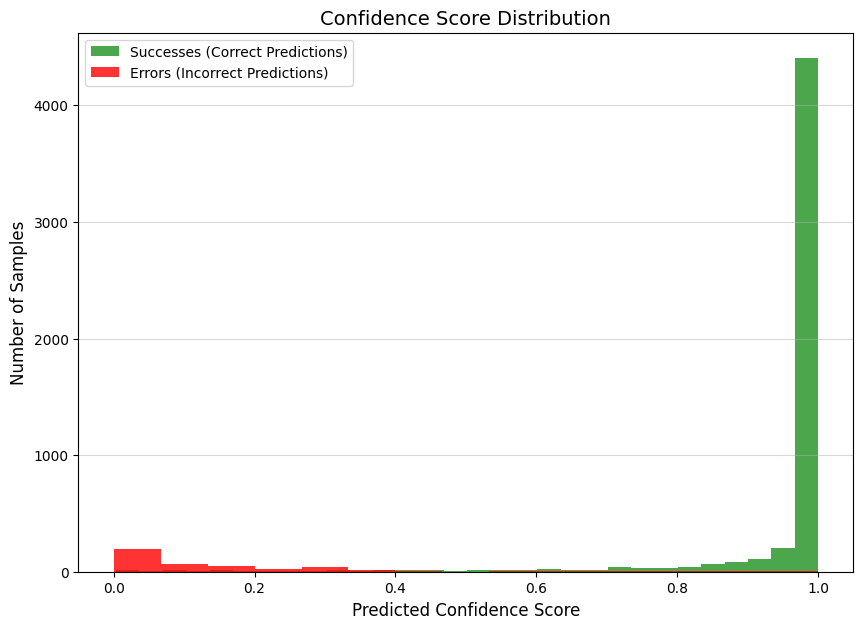

In [115]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)
is_correct = (y_hat == y_true_class)
success_confidences = confidence_scores_tcp[is_correct]
error_confidences = confidence_scores_tcp[~is_correct]

plt.figure(figsize=(10, 7))
# bins = np.linspace(0, 1, 50)
# plt.hist(success_confidences, bins=bins, alpha=0.7, label='Success', color='green')
# plt.hist(error_confidences, bins=bins, alpha=0.7, label='Error', color='red')

plt.hist(success_confidences, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
plt.hist(error_confidences, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')
plt.xlabel('Predicted Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Score Distribution', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()



In [116]:
ece_confidnet= compute_ECE(confidence_scores_tcp, y_hat, y_labels_int)
print(f"ECE for Your Learned Confidence Model (TCP*): {ece_confidnet:.4f}")

ECE for Your Learned Confidence Model (TCP*): 0.0291
